In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [16]:
metadata = pd.read_feather('/home/cmdunham/ChemicalDataGeneration/data/BKG_SIM_ims_acbc_train_v1.1.09_meta.feather')
metadata.head()

,level_0,index,Filename,TemperatureKelvin,PressureBar,PosPeak1Mobility,PosPeak2Mobility,PosPeak3Mobility,PosPeak1Amplitude,PosPeak2Amplitude,PosPeak3Amplitude,NegPeak1Mobility,NegPeak2Mobility,NegPeak3Mobility,NegPeak1Amplitude,NegPeak2Amplitude,NegPeak3Amplitude,Label
0,374419,0,JCAD_0053_2022-01-20-09-27-47_2022-01-20-14-27...,NaN,1019.5,2.290,0.0,0.0,7776.0,0.0,0.0,2.129,0.0,0.0,7279.0,0.0,0.0,BKG
1,531524,0,IMS_VX_90%_0053_2022-04-25-09-10-20_2022-04-25...,NaN,1020.3,2.283,0.0,0.0,7530.0,0.0,0.0,2.118,0.0,0.0,7062.0,0.0,0.0,BKG
2,315950,0,JCAD_0053_2022-01-20-09-34-32_2022-01-20-14-34...,NaN,1019.5,2.291,0.0,0.0,7690.0,0.0,0.0,2.130,0.0,0.0,7317.0,0.0,0.0,BKG
3,374517,0,JCAD_0053_2022-01-20-09-24-09_2022-01-20-14-24...,NaN,1019.5,2.291,0.0,0.0,7796.0,0.0,0.0,2.129,0.0,0.0,7312.0,0.0,0.0,BKG
4,374610,0,JCAD_0053_2022-01-20-09-17-04_2022-01-20-14-17...,NaN,1019.2,2.289,0.0,0.0,7682.0,0.0,0.0,2.128,0.0,0.0,7373.0,0.0,0.0,BKG


In [17]:
print('Number of unique values in each field:')
print('   Label: ', len(set(metadata['Label'])))
print('   PressureBar: ', len(set(metadata['PressureBar'])))
print('   TemperatureKelvin: ', len(set(metadata['TemperatureKelvin'])))

Number of unique values in each field:
   Label:  9
   PressureBar:  798
   TemperatureKelvin:  667


In [18]:
metadata.isna().sum()

level_0               0
index                 0
Filename              0
TemperatureKelvin    13
PressureBar           0
PosPeak1Mobility      0
PosPeak2Mobility      0
PosPeak3Mobility      0
PosPeak1Amplitude     0
PosPeak2Amplitude     0
PosPeak3Amplitude     0
NegPeak1Mobility      0
NegPeak2Mobility      0
NegPeak3Mobility      0
NegPeak1Amplitude     0
NegPeak2Amplitude     0
NegPeak3Amplitude     0
Label                 0
dtype: int64

In [19]:
# dropping the 13 rows with NaN values in "TemperatureKelvin" field.
metadata = metadata.dropna(subset='TemperatureKelvin')

# Plotting variation within numeric features:
---

In [21]:
numeric_features = [col for col in metadata.columns if metadata[col].dtype == np.float64]

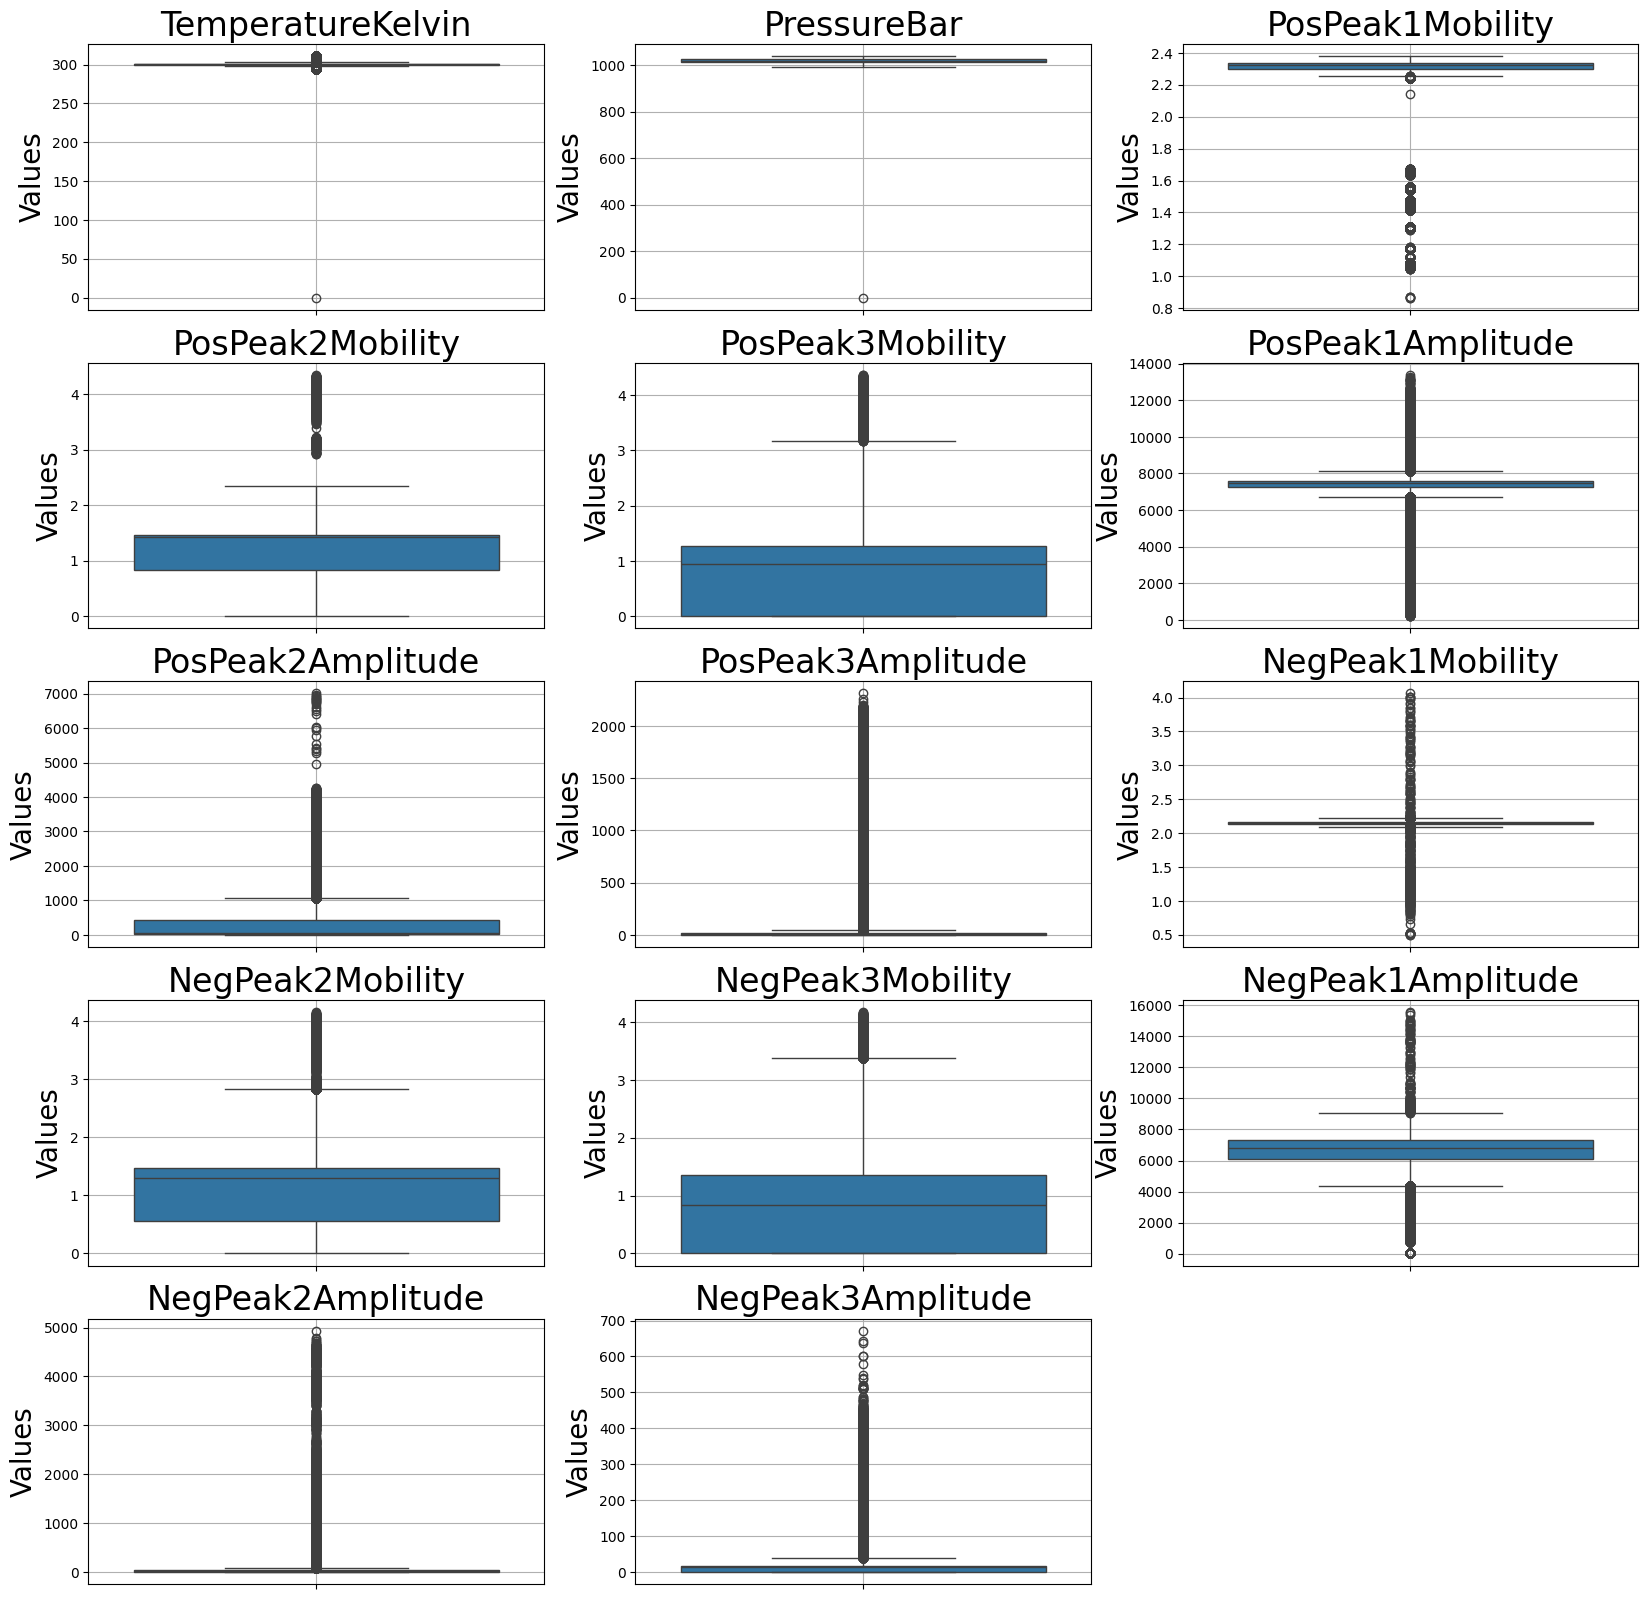

In [11]:
num_features = len(numeric_features)
cols = 3  # Number of columns for the subplots
rows = (num_features + cols - 1) // cols  # Calculate number of rows needed
fig, axes = plt.subplots(rows, cols, figsize=(20, 20))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, feature in enumerate(numeric_features):
    sns.boxplot(ax=axes[i], y=metadata[feature])
    axes[i].set_title(feature,fontsize=24)
    axes[i].set_ylabel('Values', fontsize=20)
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

In the boxplots above we can see that "TemperatureKelvin" and "PressureBar" fields have significant outliers. I'll drop those samples.

In [31]:
# removing outliers from two fields
metadata_cleaned = metadata[metadata["TemperatureKelvin"] > 0]
metadata_cleaned = metadata_cleaned[metadata_cleaned["PressureBar"] > 0]
print(f'Dropping outliers from "TemperatureKelvin" and "PressureBar" removed {metadata.shape[0] - metadata_cleaned.shape[0]} rows from the dataset.') 

Dropping outliers from "TemperatureKelvin" and "PressureBar" removed 1 rows from the dataset.


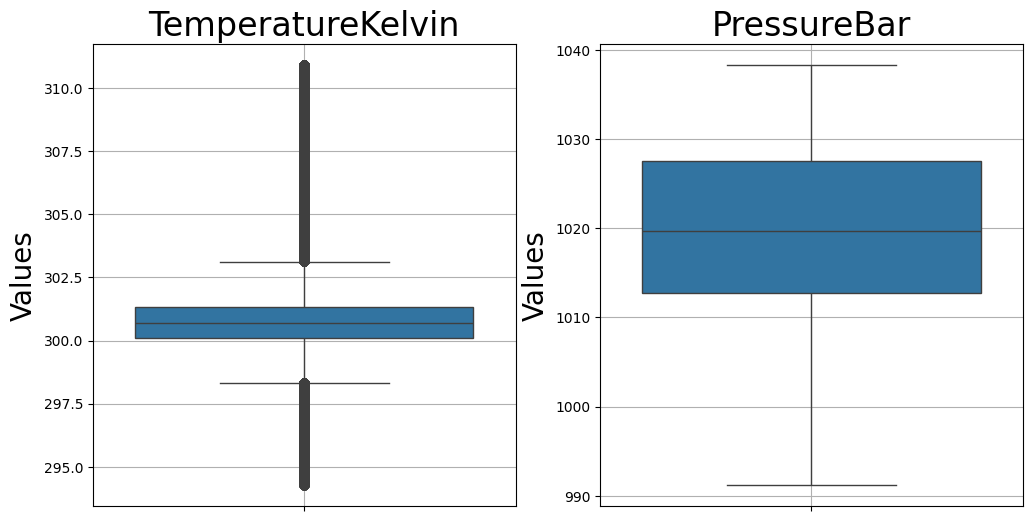

In [28]:
features = ['TemperatureKelvin', 'PressureBar']
cols = len(features)  # Number of columns for the subplots
fig, axes = plt.subplots(1, cols, figsize=(12, 6))

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, feature in enumerate(features):
    sns.boxplot(ax=axes[i], y=metadata_cleaned[feature])
    axes[i].set_title(feature,fontsize=24)
    axes[i].set_ylabel('Values', fontsize=20)
    axes[i].grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

The boxplots for these features no longer show significant outliers.

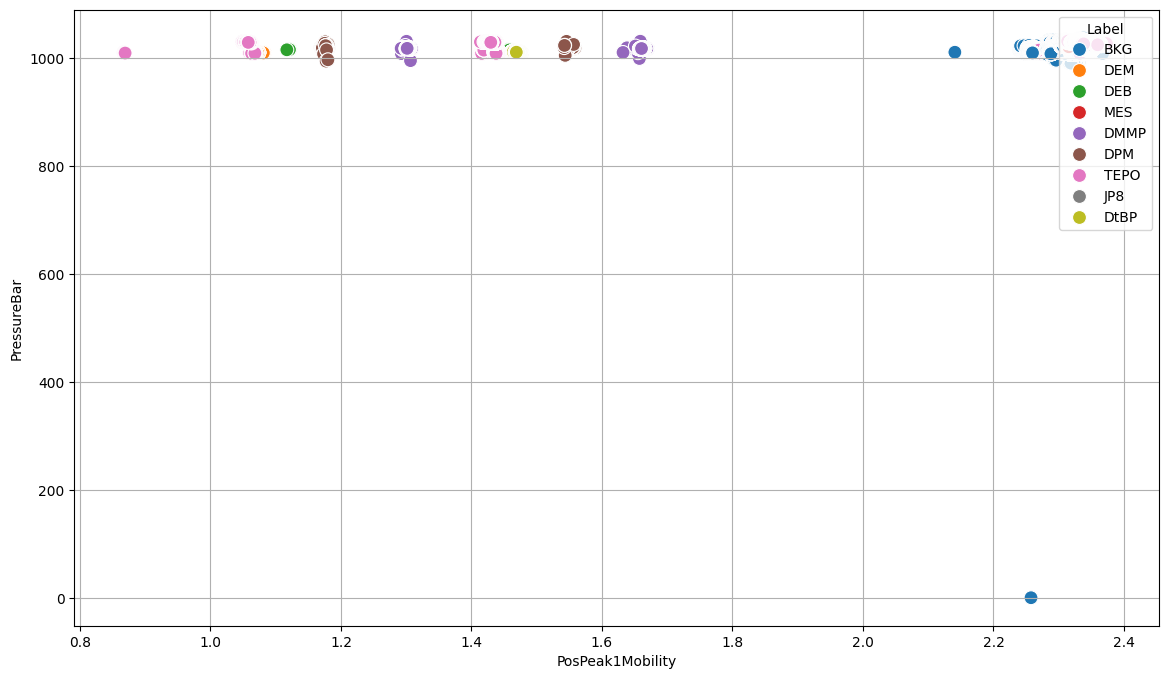

In [19]:
fig, ax = plt.subplots(figsize=(14, 8))

# Plot only a section of the df if a plot of the entire thing is difficult to interpret
# slice_num = 300
# sns.scatterplot(data=metadata[:][:slice_num], x='PosPeak1Mobility', y='Label', hue='Label', legend="brief", ax=ax, s=100)

# sns.scatterplot(data=metadata, x='PosPeak1Mobility', y='Label', hue='Label', legend="brief", ax=ax, s=100)
sns.scatterplot(data=metadata, x='PosPeak1Mobility', y='PressureBar', hue='Label', legend="brief", ax=ax, s=100)
sns.move_legend(ax, 'upper right')

# plt.xticks([])
# plt.xlabel('Collision Cross Section Average', fontsize=16)
# plt.ylabel('Molecular Formula', fontsize=16)
# plt.title('CCS Average Values Across Molecules', fontsize=20)
plt.grid()
plt.show()